# Market Research -- User Rating Behaviors
Group member: Gretch Zhang, Baihe Yuan, Jacqueline Zhou, Disheng Wen, Siyuan Chen

### Description:
This research predicts users' rating behaviors based on their browsing history. The process involves Principle Components Analysis, K-means and linear regression.


## 1) Import Data

Import Packages and load data

In [202]:
# useful packages
import numpy as np
import csv
import math
import pandas as pd
from sklearn import preprocessing
from sklearn import datasets
from sklearn import cluster
import matplotlib.pyplot as plt
import itertools
from sklearn.decomposition import PCA
import plotly.graph_objects as pgo

In [203]:
# load data as a dataframe with pandas
user_history = pd.read_csv("user_history.csv")
user_history_without_user_ID = user_history.drop(['USER ID'],axis=1)
user_ratings = pd.read_csv("user_ratings.csv")

In [204]:
# encode users as indices
le_user = preprocessing.LabelEncoder()
le_user.fit(user_history['USER ID'])

user_with_rating_index = le_user.transform(user_ratings['USER ID'])
all_user_index = le_user.transform(user_history['USER ID'])
user_ratings['USER INDEX'] = user_with_rating_index
user_ratings.head()

# encode products as indices
le_product = preprocessing.LabelEncoder()
le_product.fit(user_ratings['PRODUCT'])

product_ID = le_product.transform(user_ratings['PRODUCT'])
user_ratings['PRODUCT ID'] = product_ID
user_ratings.head()

,USER ID,PRODUCT,RATING,USER INDEX,PRODUCT ID
0,100950,secret postage,4,0,54
1,100950,violet saga,4,0,70
2,100950,pepper chicago,3,0,41
3,100950,nina sailor,2,0,35
4,100950,front salami,3,0,18


We can take the data in user_history and turn it into a matrix using the following command:

In [205]:
history_M = user_history.to_numpy()
# leave out user ID column
his_label = history_M[:,0]
# .reshape((history_M[:,0].shape[0],1))
his_M = history_M[:,1:]

For an introduction and short tutorial on pandas, you are invited to read over https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html.

## 2) Principal Component Analysis on User History data

The goal for this section is to divide the data into clusters and find the principal features to be used in the next section, linear regression, to predict the users' ratings based on their history data.

Now standardize the user history data and compute the SVD:

In [206]:
# subtract the mean
his_meanzero = his_M - np.mean(his_M, axis=1, keepdims=True)
# divide by the standard deviation
his_std = his_meanzero/np.std(his_meanzero, axis=1, keepdims=True)
# SVD
U, S, VT = np.linalg.svd(his_std, full_matrices=False)

# make a figure showing the singular values
svd_figure = pgo.Figure([pgo.Bar(x=np.arange(len(S)), y=S)])
svd_figure.show()

We conclude that we will use the first three eigenvectors of the standardized data matrix.

Now compute the eigenvectors of history data's covariance matrix:

In [207]:
# eigenvector contained in v
his_cov = np.cov(his_std.T)
w, v = np.linalg.eig(his_cov)

Try different combinations of the first tree eigenvectors as the feature matrix.

We produce the result of the PCA in this formula:
$Data = Feature^{T} * StdMatrix^{T}$

Then, we plot the transpose of the results in scatter to observe any possible patterns.

In [208]:
# state the eigenvector to be used
v1 = (v[:,0]).real
v1 = v1.reshape((v1.shape[0], 1))
v2 = (v[:,1]).real
v2 = v2.reshape((v2.shape[0], 1))
v3 = (v[:,2]).real
v3 = v3.reshape((v3.shape[0], 1))

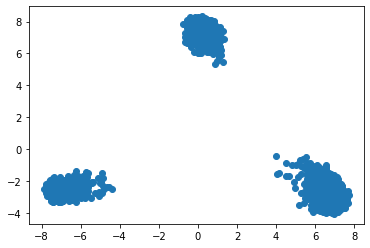

In [209]:
# v1 and v2
f_12 = np.concatenate((v1, v2), axis = 1)
his_12 = (his_std @ f_12).T
plt.scatter(his_12[0],his_12[1])

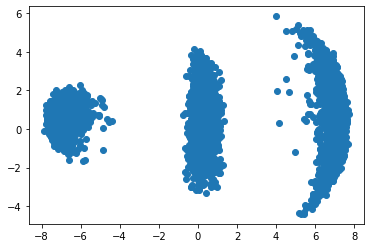

In [210]:
# v1 and v3
f_13 = np.concatenate((v1, v3), axis = 1)
his_13 = (his_std @ f_13).T
plt.scatter(his_13[0],his_13[1])

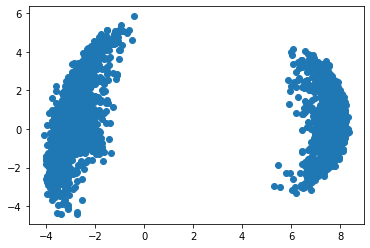

In [211]:
# v2 and v3
f_23 = np.concatenate((v2, v3), axis = 1)
his_23 = (his_std @ f_23).T
plt.scatter(his_23[0],his_23[1])

When using the first two eigenvalues to project the history data, it did give the best classification result, thus we decide to use the first two eigen values **v1** and **v2**.

As shown in the first graph, we will classify the data into 3 clusters in the next K-means step.

## 2) K-means clustering

Now we use k-means method to cluster the data into 3 parts.

[[ 1.00950000e+05  7.31094618e-01 -8.94753669e-01 ...  1.58980665e-01
   1.31720742e-01  1.23296336e-01]
 [ 1.00956000e+05  1.10938964e+00 -6.69580389e-01 ... -3.53934244e-01
   4.24670322e-01 -1.03733797e+00]
 [ 1.00962000e+05 -1.02138211e+00  2.91023343e+00 ... -1.02985095e+00
  -7.75577031e-01  2.19481007e-01]
 ...
 [ 1.25629000e+05  9.11668165e-01 -7.27845322e-01 ... -1.49643757e-02
   2.22371361e-02 -7.33299870e-01]
 [ 1.25636000e+05 -1.24583943e+00  1.54151693e+00 ... -3.22959687e-01
  -9.17915211e-01 -7.03656886e-01]
 [ 1.25645000e+05 -8.32821846e-01  5.39011111e-01 ... -4.25121028e-01
  -4.56042856e-01 -1.13749788e+00]]


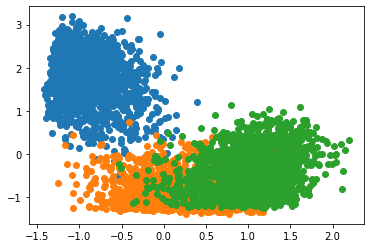

In [212]:
from sklearn.cluster import KMeans
chis_12 = KMeans(n_clusters=3)
his_label = his_label.reshape((his_label.shape[0],1))
his12 = np.concatenate((his_label,his_std), axis = 1)
print(his12)
#his12=np.transpose(his12)
chis_12.fit(his12[:,1:])

plt.figure()
for i in range(3):
    plt.plot(his12[chis_12.labels_==i, 1], his12[chis_12.labels_==i, 2], 'o')


When separatig the clusters, we want to keep the labels (User index) on track in order to place the data after PCA process back in place.

In [213]:
# cluster 1
c1 = his12[chis_12.labels_==0]
c1_label = c1[:,0].reshape((c1[:,0].shape[0],1))
c1 = c1[:,1:]
# cluster 2
c2=his12[chis_12.labels_==1]
c2_label = c2[:,0].reshape((c2[:,0].shape[0],1))
c2 = c2[:,1:]
# cluster 3
c3=his12[chis_12.labels_==2]
c3_label = c3[:,0].reshape((c3[:,0].shape[0],1))
c3 = c3[:,1:]

## 3. PCA on clusters

1. Standardize the first cluster

In [214]:
# subtract the mean
c1_meanzero = c1 - np.mean(c2, axis=1, keepdims=True)
# divide by the standard deviation
c1_std = c1_meanzero/np.std(c1_meanzero, axis=1, keepdims=True)
# SVD
U, S, VT = np.linalg.svd(c1_std, full_matrices=False)

# make a figure showing the singular values
svd_figure = pgo.Figure([pgo.Bar(x=np.arange(len(S)), y=S)])
svd_figure.show()

Compute the eigenvector of the first cluster's covariance matrix

In [215]:
# eigenvector contained in v
c1_cov = np.cov(c1_std.T)
w, v1 = np.linalg.eig(c1_cov)
v1_3=v1[:,0:3]
c1_3 = c1_std @ v1_3
c1_3 = np.concatenate((c1_label,c1_3), axis = 1)

2. Standardize the 2nd cluster

In [216]:
# subtract the mean
c2_meanzero = c2 - np.mean(c2, axis=1, keepdims=True)
# divide by the standard deviation
c2_std = c2_meanzero/np.std(c2_meanzero, axis=1, keepdims=True)
# SVD
U, S, VT = np.linalg.svd(c2_std, full_matrices=False)

# make a figure showing the singular values
svd_figure = pgo.Figure([pgo.Bar(x=np.arange(len(S)), y=S)])
svd_figure.show()

Compute the eigenvector of the second cluster's covariance matrix

In [217]:
c2_cov = np.cov(c2_std.T)
w, v2 = np.linalg.eig(c2_cov)
v2_3 = v2[:,0:3]
c2_3 = c2_std @ v2_3
c2_3 = np.concatenate((c2_label,c2_3), axis = 1)

3. Standardize the 3rd cluster

In [218]:
# subtract the mean
c3_meanzero = c3 - np.mean(c3, axis=1, keepdims=True)
# divide by the standard deviation
c3_std = c3_meanzero/np.std(c3_meanzero, axis=1, keepdims=True)
# SVD
U, S, VT = np.linalg.svd(c3_std, full_matrices=False)

# make a figure showing the singular values
svd_figure = pgo.Figure([pgo.Bar(x=np.arange(len(S)), y=S)])
svd_figure.show()

Compute the eigenvector of the 3rd cluster's covariance matrix

In [219]:
c3_cov = np.cov(c3_std.T)
w, v3 = np.linalg.eig(c3_cov)
v3_3 = v3[:,0:3]
c3_3 = c3_std @ v3_3
c3_3 = np.concatenate((c3_label,c3_3), axis = 1)

## 4) Put the processed clusters back in place

In [220]:
count_1 = 0
count_2 = 0
count_3 = 0
X = np.zeros((4500, 4))
# loop through the original labels to put clusters back in place
for i in range(X.shape[0]):
    if count_1 == 1500:
        count_1 -= 1
    if count_2 == 1500:
        count_2 -= 1
    if count_3 == 1500:
        count_3 -= 1
    if his_label[i] == c1_3[count_1,0]:
        X[i,:] = c1_3[count_1,:]
        count_1 = count_1 + 1
    elif his_label[i] == c2_3[count_2,0]:
        X[i,:] = c2_3[count_2,:]
        count_2 = count_2 + 1
    else:
        X[i,:] = c3_3[count_3,:]
        count_3 = count_3 + 1

In [221]:
print (X[0:5])

[[ 1.00950000e+05 -2.59702368e+00  1.26912601e+00  6.06181224e+00]
 [ 1.00956000e+05  1.80500661e+00  3.97689757e+00 -5.64866447e+00]
 [ 1.00962000e+05 -5.19788223e+00 -6.54200793e-01 -5.40409166e+00]
 [ 1.00969000e+05  1.12922744e+00  5.37401553e+00  4.03012679e+00]
 [ 1.00974000e+05 -4.76076334e+00  1.29635386e+00 -5.42727327e+00]]


The X is the clusters put back in original order after PCA, reserving user ID and three PCA features.

In [222]:
#display full dataset
user_ratings_table = pd.pivot_table(user_ratings,values='RATING', index='USER ID',
                    columns='PRODUCT')
user_ratings_table


PRODUCT,adrian crater,anagram mentor,apropos pizza,bandit anatomy,banjo ladder,barcode arnold,bazooka diagram,bronze mystic,calypso zigzag,casino unit,...,tourist micro,tripod stand,update lola,ventura puzzle,viking llama,violet saga,vista queen,viva avalon,voodoo planet,wheel gibson
USER ID,,,,,,,,,,,,,,,,,,,,,
100950,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
100956,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100969,NaN,10.0,1.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,0.0,NaN,NaN,8.0,2.0
100974,NaN,NaN,NaN,9.0,NaN,5.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117440,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,6.0,NaN,NaN,NaN,NaN,NaN,5.0
117442,6.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
117446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [223]:
#convert the data frame to a matrix and replace nan with zeros
userR = user_ratings_table.fillna(0)
userR = userR.to_numpy()
#userR = user_ratings_table.to_numpy()
#fill entries with nan by 0
#for i in range (len(userR)):
    #for j in range (len(userR[0])):
        #if (math.isnan(userR[i,j])):
            #userR[i,j] = 0
userR

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 9., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [224]:
#Find duplicates ID that exist in both history and ratings
duplicates = pd.merge(user_history["USER ID"], user_ratings["USER ID"], how='outer', indicator='Exist')
duplicates = duplicates.loc[duplicates['Exist'] == 'both']
duplicates

,USER ID,Exist
0,100950,both
1,100950,both
2,100950,both
3,100950,both
4,100950,both
...,...,...
33720,117449,both
33721,117449,both
33722,117449,both
33723,117449,both


In [225]:
#keep only IDs that exist in both dataset in history
user_his = user_history[user_history["USER ID"].isin(duplicates["USER ID"])]
user_his = pd.DataFrame(user_his)
user_his
userR[:,0]
print (X)

[[ 1.00950000e+05 -2.59702368e+00  1.26912601e+00  6.06181224e+00]
 [ 1.00956000e+05  1.80500661e+00  3.97689757e+00 -5.64866447e+00]
 [ 1.00962000e+05 -5.19788223e+00 -6.54200793e-01 -5.40409166e+00]
 ...
 [ 1.25629000e+05 -1.08702307e+00 -6.43732680e-01  6.75333321e+00]
 [ 1.25636000e+05  1.58789932e+00  1.95978587e+00 -6.75886986e+00]
 [ 1.25645000e+05  4.20999819e+00 -9.79977880e-01 -5.86915273e+00]]


Coefficients: 
 [-0.15627289  0.10045419  0.18088314  0.09840717 -0.09606579  0.05738816
 -0.22745738 -0.27879114 -0.19402719 -0.01781725 -0.07629769 -0.09640856
 -0.01711316  0.14183769  0.43987017 -0.42548302 -0.05370199 -0.14138967
  0.05094748 -0.02990476  0.28095832 -0.18766124  0.11833953 -0.09715069
 -0.2935032  -0.18047345  0.07887989  0.00388338  0.01789712 -0.32201804
  0.32117282 -0.18887334 -0.08628224 -0.24821569  0.22285391 -0.40863919
 -0.03985729  0.00867417  0.02053839  0.14957277 -0.21544793 -0.01105673
 -0.1755516  -0.17677167  0.30869235 -0.11967231  0.16973678  0.11320999
  0.24170644  0.06175494  0.1468441  -0.12045702 -0.15932461  0.08806965
 -0.35092353 -0.26511454  0.13509404 -0.00666074  0.04637064  0.02449703
  0.19987408 -0.29935342  0.20086279 -0.08567959 -0.12313557 -0.00153406
  0.11343604  0.03314426  0.07390504  0.08724655  0.24524159 -0.011683
 -0.15538853 -0.10308439  0.2464226  -0.03533681  0.10375116  0.15805232
  0.23195298 -0.04556665 -0.21520984 

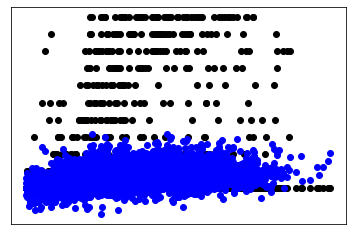

In [226]:
#fit regression model
y = userR[:,0] #set y, you can change columns of userR to fit each product to a regression model
user_hisw = user_his.drop(['USER ID'],axis=1)
n,p = user_hisw.shape
X1 = np.ones((n, p + 1)) #add intercept
X1[:, 1:] = user_hisw

#compute betahat
U, S, Vt = np.linalg.svd(X1[:,1:].T @ X1[:,1:])
betat = Vt.T @ (U.T @ (X1[:,1:].T @ y) / S)
betat
# compute predictions
y_pred = X1[:,1:] @ betat
# compute MSE
MSE = np.mean((y - y_pred) ** 2)

# The coefficients
print('Coefficients: \n', betat)
# The mean squared error
print('Mean squared error: ', MSE)

#plot the output
plt.scatter(X1[:, 3], y,  color='black')
plt.plot(X1[:, 3], y_pred, 'ob')

plt.xticks(())
plt.yticks(())

plt.show()

In [227]:
def MSE(U, V, M, obs):
    s = 0
    st = 0
    nSamp = len(obs)
    for l in range(nSamp):
        i, j = obs[l]
        s += (np.dot(U[i, :], V[j, :].T) - M[i, j])**2
    return np.sqrt(s)

# compute relative Frobenius error: NORM(UV-M, 'fro')/NORM(M, 'fro')
def RelError(U, V, M, obs):
    s = 0
    st = 0
    nSamp = len(obs)
    for l in range(nSamp):
        i, j = obs[l]
        s += (np.dot(U[i, :], V[j, :].T) - M[i, j])**2
        st += (M[i, j])**2
    return np.sqrt(s)/np.sqrt(st)

In [228]:
M = user_ratings.pivot(index='USER INDEX', columns='PRODUCT ID', values='RATING').values

user_ratingsS = user_ratings.sort_values(["USER INDEX","PRODUCT ID"])
users = user_ratingsS['USER INDEX'].values
movies = user_ratingsS['PRODUCT ID'].values
ratings = user_ratingsS['RATING'].values
obs = [(users[i], movies[i]) for i in range(len(users))]
M = sparse.coo_matrix((ratings, (users,movies))).tocsr()
print(M)

  (0, 4)	8
  (0, 8)	5
  (0, 18)	3
  (0, 24)	8
  (0, 28)	4
  (0, 31)	6
  (0, 33)	6
  (0, 34)	9
  (0, 35)	2
  (0, 41)	3
  (0, 54)	4
  (0, 57)	1
  (0, 70)	4
  (1, 5)	5
  (1, 15)	2
  (1, 28)	2
  (1, 35)	4
  (1, 36)	10
  (1, 38)	5
  (1, 44)	3
  (1, 50)	7
  (2, 11)	7
  (2, 17)	4
  (2, 22)	7
  (2, 23)	9
  :	:
  (2997, 40)	0
  (2997, 58)	8
  (2997, 65)	5
  (2998, 8)	3
  (2998, 17)	6
  (2998, 20)	5
  (2998, 21)	6
  (2998, 23)	8
  (2998, 26)	3
  (2998, 32)	5
  (2998, 33)	2
  (2998, 41)	2
  (2998, 45)	1
  (2998, 50)	8
  (2998, 58)	3
  (2998, 61)	6
  (2998, 67)	1
  (2998, 73)	9
  (2999, 7)	4
  (2999, 14)	7
  (2999, 16)	8
  (2999, 19)	4
  (2999, 59)	7
  (2999, 64)	3
  (2999, 65)	7


In [229]:
# Matrix completion via gradient descent
class Matrix_completion():
    
    def __init__(self, R, K, alpha, beta, iters):
        
        self.R = R
        self.users, self.movies = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iters = iters
        """ 
        R = the input dataset
        num_users = user features
        num_movies = movie features
        K = low rank approxiamation
        alpha = the learning rate
        beta = regularization
        iters = number of iterations
        """
    # training process by sgd
    def train(self):
        # construct two random matrix for Pt, Qt
        self.Pt = np.random.normal(scale=1./self.K, size=(self.users, self.K))
        self.Qt = np.random.normal(scale=1./self.K, size=(self.movies, self.K))
        
        # construct matrix for bias
        self.userb = np.zeros(self.users)
        self.movieb = np.zeros(self.movies)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        # Create a training sample
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.users)
            for j in range(self.movies)
            if self.R[i, j] > 0
        ]
        
        # SGD with defined iterations
        training = []
        for i in range(self.iters):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))
        
        return training
    
    # compute the mean square error
    def mse(self):
        
        xs, ys = self.R.nonzero()
        predicted = self.approximation()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    #compute SGD
    def sgd(self):
        
        for i, j, r in self.samples:
            # Compute prediction and error
            prediction = self.Prediction(i, j)
            e = (r - prediction)
            
            # Update biases
            self.userb[i] += self.alpha * (e - self.beta * self.userb[i])
            self.movieb[j] += self.alpha * (e - self.beta * self.movieb[j])
            
            # create another P since we need previous P to compute Q
            P_i = self.Pt[i, :][:]
            
            # update predicted ratings
            self.Pt[i, :] += self.alpha * (e * self.Qt[j, :] - self.beta * self.Pt[i,:])
            self.Qt[j, :] += self.alpha * (e * P_i - self.beta * self.Qt[j,:])
      
    # compute predictions
    def Prediction(self, i, j):
        
        prediction = self.b + self.userb[i] + self.movieb[j] + self.Pt[i, :].dot(self.Qt[j, :].T)
        return prediction
    
    # compute the estimated full matrix of ratings by Pt, Qt and bias
    def approximation(self):
        
        return mf.b + mf.userb[:,np.newaxis] + mf.movieb[np.newaxis:,] + mf.Pt.dot(mf.Qt.T)


In [230]:
mf = Matrix_completion(userR, K=10, alpha=0.01, beta=0.001, iters=50)

In [231]:
training = mf.train()
print(mf.approximation())
sd = mf.approximation()

Iteration: 10 ; error = 113.1295
Iteration: 20 ; error = 65.8982
Iteration: 30 ; error = 54.1774
Iteration: 40 ; error = 48.7215
Iteration: 50 ; error = 45.4744
[[ 5.31250953  8.24899056  6.28869174 ...  3.77679637  7.30708456
   6.29360181]
 [ 2.06861758  7.97708229  7.33721164 ...  6.84295932  3.3875122
   7.19602025]
 [ 3.96194621  7.90263881  4.4815464  ...  9.05265899  6.38272761
   8.22333764]
 ...
 [ 6.67661006 -1.18107363  2.59373751 ...  1.21739414  5.05775596
  -3.44333701]
 [ 9.65990513  9.13673348  2.61049353 ...  4.36843413  8.68263083
   7.37036258]
 [10.16477272  7.56880472  1.75296823 ...  6.35548992  6.76157198
   9.96619357]]


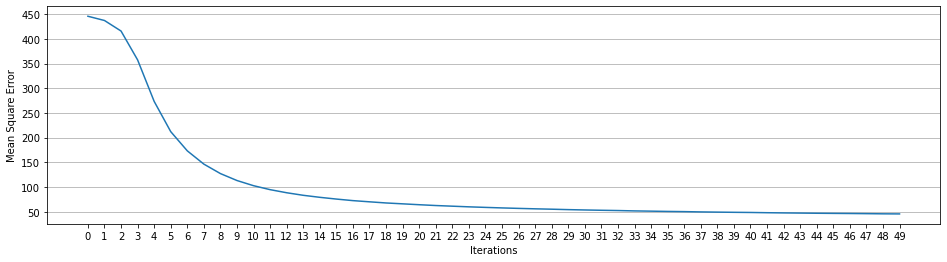

In [232]:
#plot the convergence of mean square error
x = [x for x, y in training]
y = [y for x, y in training]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

In [234]:
print(X)
print(X.shape)

[[ 1.00950000e+05 -2.59702368e+00  1.26912601e+00  6.06181224e+00]
 [ 1.00956000e+05  1.80500661e+00  3.97689757e+00 -5.64866447e+00]
 [ 1.00962000e+05 -5.19788223e+00 -6.54200793e-01 -5.40409166e+00]
 ...
 [ 1.25629000e+05 -1.08702307e+00 -6.43732680e-01  6.75333321e+00]
 [ 1.25636000e+05  1.58789932e+00  1.95978587e+00 -6.75886986e+00]
 [ 1.25645000e+05  4.20999819e+00 -9.79977880e-01 -5.86915273e+00]]
(4500, 4)


In [244]:
betat = np.linalg.lstsq(X[:3000,1:],sd[:,0],rcond=None)[0]

betat

array([-0.12323831, -0.23678196, -0.29105817])

In [236]:
'''# Make a prediction with coefficients
def predict(row, coefficients):
    yhat = coefficients[0]
    for i in range(len(row)-1):
        yhat += coefficients[i + 1] * row[i]
    return yhat
 
# Estimate linear regression coefficients using stochastic gradient descent
def coefficients_sgd(train, l_rate, n_epoch):
    coef = [0.0 for i in range(len(train[0]))]
    for epoch in range(n_epoch):
        sum_error = 0
        for row in train:
            yhat = predict(row, coef)
            error = yhat - row[-1]
            sum_error += error**2
            coef[0] = coef[0] - l_rate * error
            for i in range(len(row)-1):
                coef[i + 1] = coef[i + 1] - l_rate * error * row[i]
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
    return coef
 
# Calculate coefficients
dataset = [[1, 1], [2, 3], [4, 3], [3, 2], [5, 5]]
l_rate = 0.001
n_epoch = 50
coef = coefficients_sgd(dataset, l_rate, n_epoch)
print(coef)'''

"# Make a prediction with coefficients\ndef predict(row, coefficients):\n    yhat = coefficients[0]\n    for i in range(len(row)-1):\n        yhat += coefficients[i + 1] * row[i]\n    return yhat\n \n# Estimate linear regression coefficients using stochastic gradient descent\ndef coefficients_sgd(train, l_rate, n_epoch):\n    coef = [0.0 for i in range(len(train[0]))]\n    for epoch in range(n_epoch):\n        sum_error = 0\n        for row in train:\n            yhat = predict(row, coef)\n            error = yhat - row[-1]\n            sum_error += error**2\n            coef[0] = coef[0] - l_rate * error\n            for i in range(len(row)-1):\n                coef[i + 1] = coef[i + 1] - l_rate * error * row[i]\n        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))\n    return coef\n \n# Calculate coefficients\ndataset = [[1, 1], [2, 3], [4, 3], [3, 2], [5, 5]]\nl_rate = 0.001\nn_epoch = 50\ncoef = coefficients_sgd(dataset, l_rate, n_epoch)\nprint(coef)"

In [237]:
'''m = np.array([0.,0.,0.])
c = 0
XX = X[:3000,:]
L = 0.0001
epochs = 1000

n = float (len(XX[0]))
Y = sd[:,0]

for i in range (epochs):
    Y_pred = XX @ m + c
    D_m = (-2/n) * sum(XX * (Y - Y_pred))
    D_c = (-2/n) * sum(Y - Y_pred)
    m = m - L * D_m
    c = c - L * D_c
    
print (m,c)

print (XX @ m) '''

'm = np.array([0.,0.,0.])\nc = 0\nXX = X[:3000,:]\nL = 0.0001\nepochs = 1000\n\nn = float (len(XX[0]))\nY = sd[:,0]\n\nfor i in range (epochs):\n    Y_pred = XX @ m + c\n    D_m = (-2/n) * sum(XX * (Y - Y_pred))\n    D_c = (-2/n) * sum(Y - Y_pred)\n    m = m - L * D_m\n    c = c - L * D_c\n    \nprint (m,c)\n\nprint (XX @ m) '

In [306]:
X2 = np.delete(X,0,1)
X2 = X2[:3000,:]
def s_grad_F_j(beta, X, Y):
    return 2 * (X @ beta - Y) * X

niter = 1000
n = 3000
betat1 = np.zeros((niter, len(X2[0])))
XtX = X2.T @ X2
eta = 0.001
result = np.zeros((75,3))  

for i in range (len(sd[0])):
    Y = sd[:,i]
    #eta = 0.01
    for t in range(1, niter):
        j = np.random.randint(n)
        betat1[t, :] = betat1[t-1, :] - eta * s_grad_F_j(betat1[t-1, :], X2[j, :], Y[j])
        
    result[i,:] = betat1[-1,:]

print (result.shape)
print (result)


'''npts = 100
x = np.linspace(-1, 3, npts)
y = np.linspace(-1, 3, npts)

z = np.zeros((npts, npts))
for i in range(npts):
    for j in range(npts):
        z[j, i] = F([x[i], y[j]], X, Y)
        


fig, axs = plt.subplots(1,1, figsize = (10, 5))
axs.contour(x, y, z)
axs.plot(betahat[0], betahat[1], 'bo', markersize = 15)
axs.plot(betat[:,0], betat[:, 1], 'ro-')'''

(75, 3)
[[-0.06064155 -0.18799705 -0.31862852]
 [-0.46700883  0.43999991 -0.23977145]
 [ 0.14891433  0.49449376 -0.50975893]
 [-0.44545273 -0.54640016 -0.19692428]
 [-0.58740247 -0.1513071  -0.18422082]
 [-0.34741812 -0.22420908 -0.1961621 ]
 [ 0.03608046  0.15215437 -0.51098627]
 [ 0.48095281  0.29120637 -0.40915033]
 [ 0.49508364  0.00942237 -0.0261145 ]
 [ 0.32186531  0.51586167 -0.30406182]
 [ 0.29704172 -0.06161017 -0.2396634 ]
 [-0.1462166  -0.16004496 -0.46420619]
 [-0.268762   -0.04493409 -0.14702768]
 [ 0.24686063  0.70026584 -0.10671911]
 [-0.09666374 -0.33442525 -0.59074637]
 [ 0.40412469 -0.22634175 -0.20145735]
 [ 0.32747466 -0.07806174 -0.16552853]
 [ 0.16734337 -0.14060314 -0.09560854]
 [-0.16023282 -0.68905729 -0.51106346]
 [ 0.26506113 -0.15139515 -0.41536072]
 [-0.36046254 -0.333692   -0.12906216]
 [-0.14884826  0.3782546  -0.2285938 ]
 [-0.15494909  0.10072557 -0.10411952]
 [-0.44911494  0.40451508 -0.2540443 ]
 [-0.12801171  0.20812906 -0.57411349]
 [ 0.17916599 -0.

"npts = 100\nx = np.linspace(-1, 3, npts)\ny = np.linspace(-1, 3, npts)\n\nz = np.zeros((npts, npts))\nfor i in range(npts):\n    for j in range(npts):\n        z[j, i] = F([x[i], y[j]], X, Y)\n        \n\n\nfig, axs = plt.subplots(1,1, figsize = (10, 5))\naxs.contour(x, y, z)\naxs.plot(betahat[0], betahat[1], 'bo', markersize = 15)\naxs.plot(betat[:,0], betat[:, 1], 'ro-')"

In [307]:
# compute predictions

print (X2.shape)
print (result.shape)

y_p = X2 @ result.T # prediction
y_p

(3000, 3)
(75, 3)


array([[-2.01257066,  0.31779881, -2.84922207, ..., -2.66431995,
        -0.48671566,  1.66658621],
       [ 0.94272217,  2.26126904,  5.11479952, ...,  3.3094312 ,
        -2.16280915,  0.37666138],
       [ 2.16009319,  3.43535552,  1.65724665, ...,  2.03846526,
         1.28965312,  6.38269132],
       ...,
       [ 1.30705062, -1.49492208,  3.2214745 , ...,  2.50451351,
        -0.49607009, -4.64576985],
       [ 2.5880822 ,  2.05476509,  1.73132267, ...,  2.32697271,
         1.75427528,  4.07170186],
       [-2.23197328, -1.85187369, -0.91896418, ..., -1.68823499,
        -1.86467602, -4.15690441]])